### 1. Introduction

Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

In this notebook, I will apply my machine learning skills to predict credit default. Specifically, I will leverage the Kaggle's "American Express - Default Prediction" Competition data set to build a machine learning model. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information.


The objective is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.


The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


My purpose in this notebook is to explore and model the time series component of the data.

### 2. Key Findings

- In this notebook, I used a simple LSTM network to train time series credit card data from customers.

- I was only able to include a subset of the data in the notebook, since otherwise I was running into memory issues.

- The competition metric I got from this model was 0.635. To improve this result, I will try to solve the memory issue so that I can train the model on the whole dataset.

### 3. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

/tmp/ipykernel_32/118657098.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


### 4. Load Dataset

The dataset of this competition has a considerable size. If I read the original csv files, the data barely fits into memory. That's why I read the data from @munumbutt's AMEX-Feather-Dataset. In this Feather file, the floating point precision has been reduced from 64 bit to 16 bit. And reading a Feather file is faster than reading a csv file because the Feather file format is binary.

There are 5.5 million rows of data in this dataset. I ran out of memory in the model training stage. So I am only reading the first 900000 rows of data.

I will focus on the numerical features. There are 11 categorical features, which I will drop.

In [2]:
train_data = pd.read_feather("../input/amexfeather/train_data.ftr").iloc[:900000,:]
categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

train_data = train_data.drop(columns = categorical_features)
train_data['Date Time'] = pd.to_datetime(train_data['S_2'], format='%d.%m.%Y %H:%M:%S')
train_data = train_data.drop(columns='S_2')

### 5. Preprocess the Data

80% of the customers have 13 statements. The remaining 20% of the customers have 1 to 12 statements. For purpose of time-series modelling, I will only include customers that have 13 statements.

In [3]:
train_data.customer_ID.value_counts().value_counts().sort_index(ascending=False)

count
13    62796
12     1765
11      903
10     1127
9      1058
8       987
7       875
6       893
5       749
4       779
3       938
2       930
1       833
Name: count, dtype: int64

In [4]:
train_data = train_data[train_data['customer_ID'].map(train_data['customer_ID'].value_counts()) == 13]


There is a significant number of missing data. It is not reasonable to drop all columns or rows that have a missing value.

Neural networks can not deal with missing values. So I need to impute values for NNs. I will sort the train data first by costumer_ID and then by date (S_2). I will then interpolate linearly the missing values,

In [5]:
null= pd.DataFrame(train_data.isnull().sum(),columns=['number_of_nulls'])
null['percentage_of_null'] = round(((null['number_of_nulls']/len(train_data))*100) , 2)
null = null[null['number_of_nulls']>0]
null= null.sort_values(by='percentage_of_null',ascending=False)
null.head(10)

,number_of_nulls,percentage_of_null
D_87,815763,99.93
D_88,815419,99.89
D_108,812336,99.51
D_73,812123,99.48
D_110,811175,99.37
D_111,811175,99.37
B_39,810808,99.32
B_42,805102,98.62
D_135,789798,96.75
D_138,789798,96.75


In [6]:
train_data = train_data.sort_values(['customer_ID', 'Date Time'])
train_data.interpolate(method='linear', inplace=True, limit_direction='both')
#train_data = train_data.fillna(0)
train_data.isnull().sum().sum()

0

In [7]:
train_data.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target,Date Time
count,816348.000000,816348.000000,816348.000000,8.163480e+05,816348.000000,816348.000000,8.163480e+05,8.163480e+05,816348.000000,8.163480e+05,...,8.163480e+05,8.163480e+05,816348.000000,816348.000000,816348.000000,816348.000000,8.163480e+05,8.163480e+05,816348.000000,816348
mean,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.232706,2017-09-15 15:22:29.054080
min,-0.421143,0.000000,-1.536133,6.556511e-07,0.000000,-0.347900,5.960464e-08,1.192093e-07,-0.000325,8.940697e-07,...,5.960464e-07,5.960464e-08,0.000000,0.000000,-0.014442,0.000000,5.960464e-08,5.960464e-08,0.000000,2017-03-01 00:00:00
25%,0.498535,0.004528,0.008644,1.083984e-01,0.002880,0.128052,2.889633e-03,5.260468e-03,0.059540,4.333496e-02,...,4.898071e-03,3.017426e-03,0.002556,0.003029,0.239502,0.003029,2.754211e-03,3.017426e-03,0.000000,2017-06-09 00:00:00
50%,0.713379,0.009064,0.029953,8.144531e-01,0.005745,0.163696,5.764008e-03,9.803772e-03,0.126221,8.911133e-02,...,9.635925e-03,6.023407e-03,0.005104,0.006027,0.386719,0.006027,5.516052e-03,6.015778e-03,0.000000,2017-09-16 00:00:00
75%,0.872559,0.238403,0.123901,1.002930e+00,0.008598,0.242432,8.644104e-03,1.635742e-01,0.226196,1.783447e-01,...,3.190918e-01,9.040833e-03,0.007645,0.009041,0.530273,0.009033,8.270264e-03,9.033203e-03,0.000000,2017-12-23 00:00:00
max,1.009766,5.332031,1.324219,1.009766e+00,3.005859,3.378906,6.796875e+00,1.625000e+00,2.222656,1.007812e+01,...,3.003906e+00,1.009766e+00,1.009766,1.253906,1.840820,1.009766,1.343750e+00,4.554688e+00,1.000000,2018-03-31 00:00:00
std,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.422557,NaN


Let's visualize a few features as a function of time and see how they evolve.

We have 177 features. I will select top 10 features to plot. Top features are selected based on the LightGBM feature importance I did in another notebook.

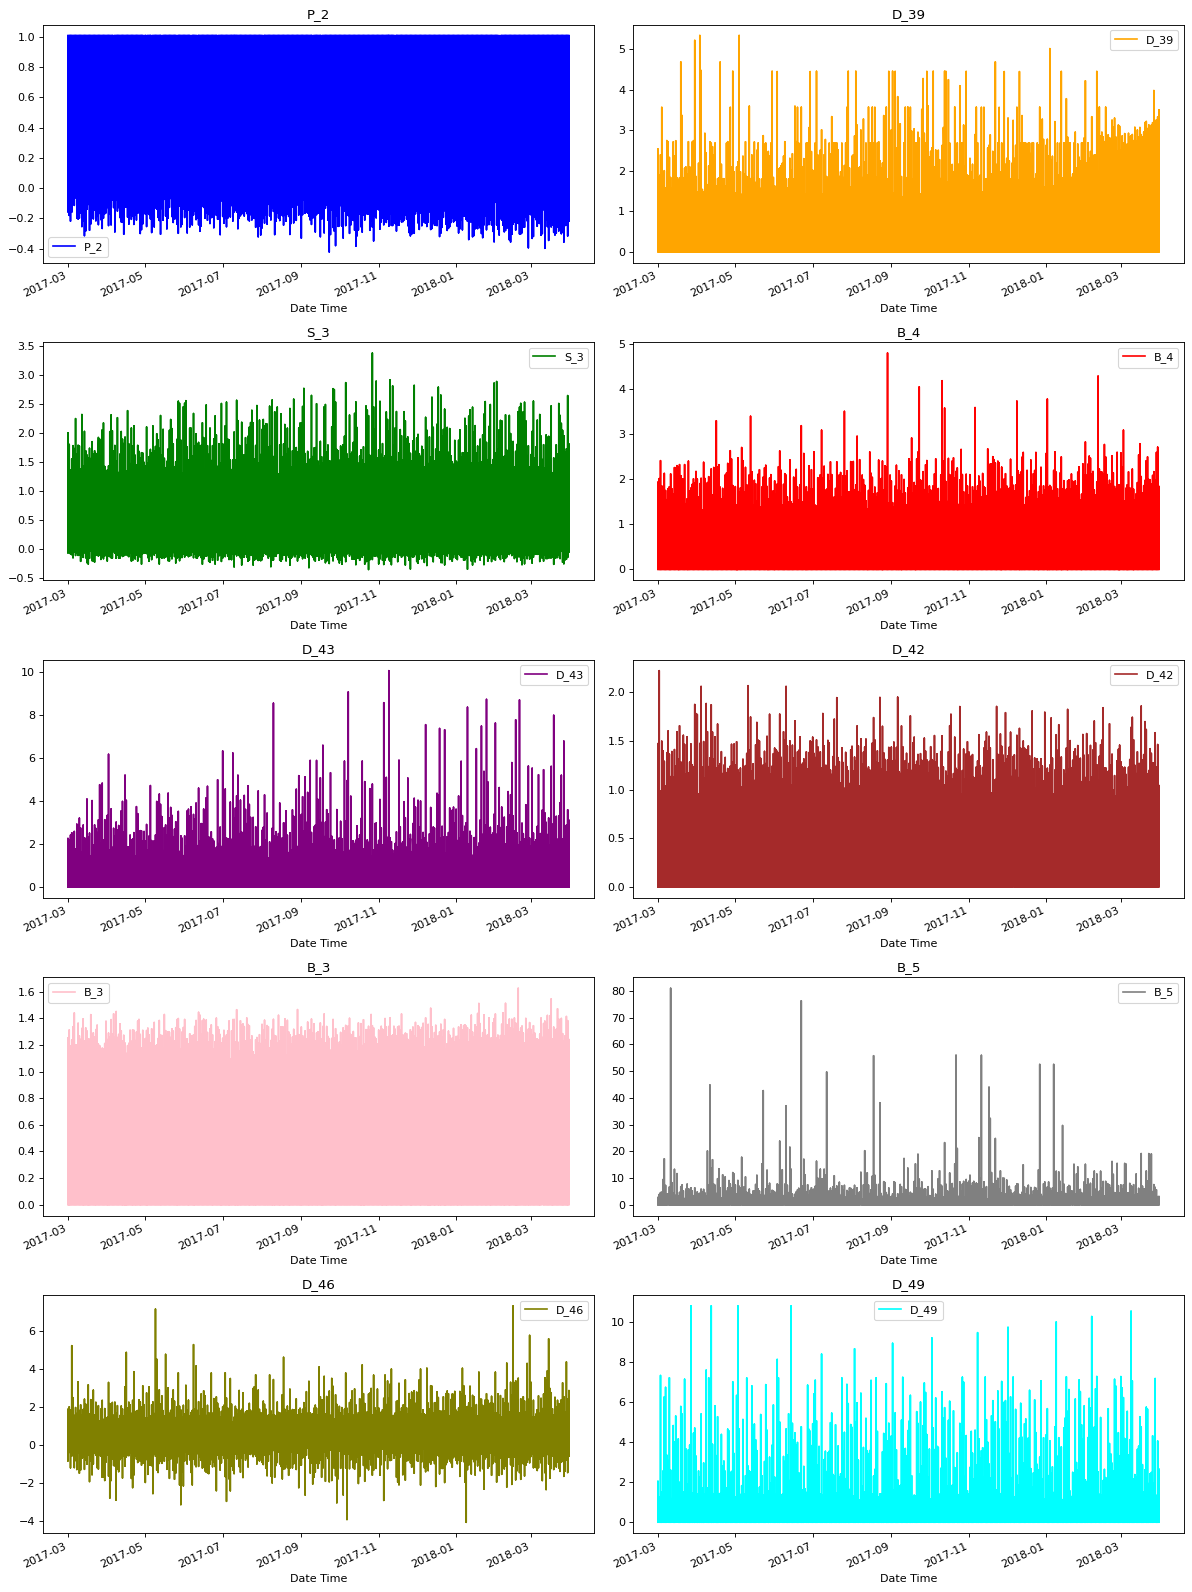

In [8]:
# Most important features based on LGBM feature importance
top_features = ["P_2","D_39", "S_3","B_4", "D_43","D_42","B_3","B_5","D_46","D_49"]
titles = top_features

colors = ["blue",  "orange",  "green",  "red",  "purple",  "brown",  "pink",  "gray",  "olive",  "cyan"]

def show_raw_visualization(data):
    time_data = data['Date Time']
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(top_features)):
        key = top_features[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(titles[i]),
            rot=25)
        ax.legend([titles[i]])
    plt.tight_layout()

show_raw_visualization(train_data)

### Standardize the Data

Each feature has a different range. This is not ideal for a neural network. In general It is better to normalize the input values. Data normalization is a crucial preprocessing step when working with neural networks to ensure stable and efficient training, faster convergence, and better generalization on the data

I will do normalization to confine feature values to a range of [0, 1] before training a neural network. I do this by subtracting the mean and dividing by the standard deviation of each feature.

In [9]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

75% of the data will be used to train the model.

25% of the data will be used for validation.

In [10]:
train_data.index = train_data['Date Time']
split_fraction = 0.75
train_split = int(split_fraction * int(train_data.shape[0]))
train_split = train_split + 13 - train_split%13
train_data.iloc[:,1:-2] = normalize(train_data.iloc[:,1:-2].values, train_split)

tra_data = train_data.iloc[0 : train_split - 1]
val_data = train_data.iloc[train_split:]
del train_data

/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [11]:
x_train = tra_data.iloc[:,1:-1].values
y_train = tra_data['target'].values
print(x_train.shape)
print(y_train.shape)

(612273, 178)
(612273,)


In [12]:
x_val = val_data.iloc[:,1:-1].values
y_val = val_data['target'].values
print(x_val.shape)
print(y_val.shape)

(204074, 178)
(204074,)


The timeseries_dataset_from_array function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and targets sampled from the main timeseries.

The following is the train and the validation datasets.

In [13]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=13,
    sampling_rate=1,
    batch_size=512,
)


dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=13,
    sampling_rate=1,
    batch_size=512,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (512, 13, 178)
Target shape: (512,)


### 6. Model Training

I will define a simple Long Short-Term Memory (LSTM) network using the Keras API.

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that is well-suited for learning from sequences of data. It is designed to overcome the limitations of traditional RNNs in capturing long-term dependencies in sequential data.

In sequential data, such as time series data, the order of the elements carries crucial information. However, traditional RNNs face challenges in learning and retaining information over long sequences due to the vanishing gradient problem, where the gradients of the loss function tend to become very small, leading to slow or no learning.

I will use binary_crossentropy as my loss metric. Binary Cross Entropy, also known as Log Loss, is a loss function used in binary classification tasks. It measures the performance of a classification model whose output is a probability value between 0 and 1.

I will use sigmoid as much activation output layer. The sigmoid activation function is appropriate for use as the output layer of a binary classification model, where it squashes the final output to represent the probability of belonging to a certain class.

Let's see how this simple network will perform for this dataset.

In [14]:
learning_rate=0.0001

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1, activation="sigmoid")(lstm_out)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 178)]         0         
                                                                 
 lstm (LSTM)                 (None, 32)                27008     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27,041
Trainable params: 27,041
Non-trainable params: 0
_________________________________________________________________


I will use the ModelCheckpoint callback to regularly save checkpoints.

I will use EarlyStopping callback to interrupt training when the validation loss is not longer improving.

In [15]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.00001, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/50
1195/1196 [============================>.] - ETA: 0s - loss: 0.4046
Epoch 1: val_loss improved from inf to 0.19930, saving model to model_checkpoint.h5
1196/1196 [==============================] - 124s 101ms/step - loss: 0.4047 - val_loss: 0.1993
Epoch 2/50
1195/1196 [============================>.] - ETA: 0s - loss: 0.1320
Epoch 2: val_loss improved from 0.19930 to 0.10199, saving model to model_checkpoint.h5
1196/1196 [==============================] - 120s 100ms/step - loss: 0.1323 - val_loss: 0.1020
Epoch 3/50
1195/1196 [============================>.] - ETA: 0s - loss: 0.0794
Epoch 3: val_loss improved from 0.10199 to 0.07591, saving model to model_checkpoint.h5
1196/1196 [==============================] - 101s 84ms/step - loss: 0.0797 - val_loss: 0.0759
Epoch 4/50
1195/1196 [============================>.] - ETA: 0s - loss: 0.0607
Epoch 4: val_loss improved from 0.07591 to 0.06132, saving model to model_checkpoint.h5
1196/1196 [==============================] - 103s 86

The model stopped after 28 epochs, because validation loss was no longer improving.

### Visualize Loss

I will visualize the loss with the function below. At one point, the validation loss stops decreasing, even though the training loss keeps going down.

The training was stopped when validation loss was no longer decreasing (Early Stpping).

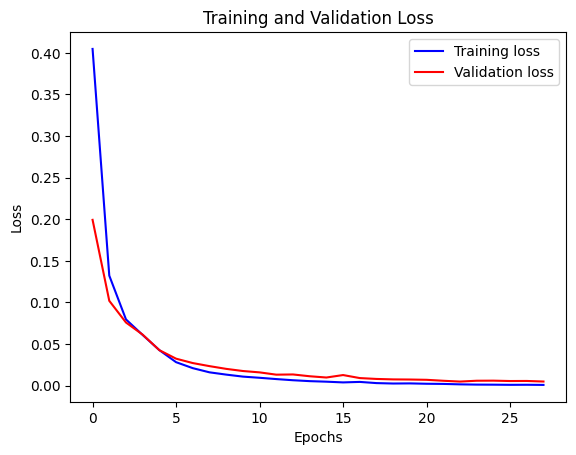

In [16]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


### Prediction


In [17]:
y_pred = model.predict(dataset_val)

399/399 [==============================] - 23s 55ms/step


### Competition Metric

The evaluation metric, 𝑀, for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, 𝐺, and default rate captured at 4%, 𝐷.

𝑀=0.5⋅(𝐺+𝐷)

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics 𝐺 and 𝐷, the negative labels are given a weight of 20 to adjust for downsampling.

This metric has a maximum value of 1.0.

This is the code for calculating this metric, provided by the competition.


In [18]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename('prediction')
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [19]:
y_pred = pd.Series(y_pred.reshape(y_pred.shape[0])).rename('prediction', inplace=True)
y_true = pd.Series(y_val).reset_index(drop=True).rename('target', inplace=True)
y_pred = y_pred.reset_index(drop=True)

In [20]:
amex_metric(y_true, y_pred)

0.9994825410970885

### Insights:

- The competition metric I got from my neural network was 0.635. This is not bad and it is better than a random chance.

- There are ways to improve these results. My next step is to try tf.data API to solve the memory issues. That will allow me to include all the training data for my model training.

- Another future step for this project would be to use keras tuner to tune hyperparameters, number of layers, learning rate, etc.